In [33]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random

# Définition des fonctions utiles

In [34]:
# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# Compare normalized strings.
def compare_strings(x, y):
    try:
        return str(x).strip().casefold()==str(y).strip().casefold()
    except AttributeError: # For Python 2.x compatibility
        return str(x).strip().lower()==str(y).strip().lower()

# Find patient data files.
def find_patient_files(data_folder):
    # Find patient files.
    filenames = list()
    for f in sorted(os.listdir(data_folder)):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.txt':
            filename = os.path.join(data_folder, f)
            filenames.append(filename)

    # To help with debugging, sort numerically if the filenames are integers.
    roots = [os.path.split(filename)[1][:-4] for filename in filenames]
    if all(is_integer(root) for root in roots):
        filenames = sorted(filenames, key=lambda filename: int(os.path.split(filename)[1][:-4]))
        
    return filenames

# Load patient data as a string.
def load_patient_data(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data

# Load a WAV file.
def load_wav_file(filename):
    frequency, recording = sp.io.wavfile.read(filename)
    return recording, frequency

# Load recordings.
def load_recordings_AV(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        if 'AV.wav' in filename:
            recording, frequency = load_wav_file(filename)
            recordings.append(recording)
            frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

# Load recordings.
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

# Get patient ID from patient data.
def get_patient_id(data):
    patient_id = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                patient_id = l.split(' ')[0]
            except:
                pass
        else:
            break
    return patient_id

# Get number of recording locations from patient data.
def get_num_locations(data):
    num_locations = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                num_locations = int(l.split(' ')[1])
            except:
                pass
        else:
            break
    return num_locations

# Get frequency from patient data.
def get_frequency(data):
    frequency = None
    for i, l in enumerate(data.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency

# Get recording locations from patient data.
def get_locations(data):
    num_locations = get_num_locations(data)
    locations = list()
    for i, l in enumerate(data.split('\n')):
        entries = l.split(' ')
        if i==0:
            pass
        elif 1<=i<=num_locations:
            locations.append(entries[0])
        else:
            break
    return locations

# Get age from patient data.
def get_age(data):
    age = None
    for l in data.split('\n'):
        if l.startswith('#Age:'):
            try:
                age = l.split(': ')[1].strip()
            except:
                pass
    return age

# Get sex from patient data.
def get_sex(data):
    sex = None
    for l in data.split('\n'):
        if l.startswith('#Sex:'):
            try:
                sex = l.split(': ')[1].strip()
            except:
                pass
    return sex

# Get height from patient data.
def get_height(data):
    height = None
    for l in data.split('\n'):
        if l.startswith('#Height:'):
            try:
                height = float(l.split(': ')[1].strip())
            except:
                pass
    return height

# Get weight from patient data.
def get_weight(data):
    weight = None
    for l in data.split('\n'):
        if l.startswith('#Weight:'):
            try:
                weight = float(l.split(': ')[1].strip())
            except:
                pass
    return weight

# Get pregnancy status from patient data.
def get_pregnancy_status(data):
    is_pregnant = None
    for l in data.split('\n'):
        if l.startswith('#Pregnancy status:'):
            try:
                is_pregnant = bool(sanitize_binary_value(l.split(': ')[1].strip()))
            except:
                pass
    return is_pregnant

# Get murmur from patient data.
def get_murmur(data):
    murmur = None
    for l in data.split('\n'):
        if l.startswith('#Murmur:'):
            try:
                murmur = l.split(': ')[1]
            except:
                pass
    if murmur is None:
        raise ValueError('No murmur available. Is your code trying to load labels from the hidden data?')
    return murmur

# Get outcome from patient data.
def get_outcome(data):
    outcome = None
    for l in data.split('\n'):
        if l.startswith('#Outcome:'):
            try:
                outcome = l.split(': ')[1]
            except:
                pass
    if outcome is None:
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    return outcome

# Sanitize binary values from Challenge outputs.
def sanitize_binary_value(x):
    x = str(x).replace('"', '').replace("'", "").strip() # Remove any quotes or invisible characters.
    if (is_finite_number(x) and float(x)==1) or (x in ('True', 'true', 'T', 't')):
        return 1
    else:
        return 0

# Santize scalar values from Challenge outputs.
def sanitize_scalar_value(x):
    x = str(x).replace('"', '').replace("'", "").strip() # Remove any quotes or invisible characters.
    if is_finite_number(x) or (is_number(x) and np.isinf(float(x))):
        return float(x)
    else:
        return 0.0

# Save Challenge outputs.
def save_challenge_outputs(filename, patient_id, classes, labels, probabilities):
    # Format Challenge outputs.
    patient_string = '#{}'.format(patient_id)
    class_string = ','.join(str(c) for c in classes)
    label_string = ','.join(str(l) for l in labels)
    probabilities_string = ','.join(str(p) for p in probabilities)
    output_string = patient_string + '\n' + class_string + '\n' + label_string + '\n' + probabilities_string + '\n'

    # Write the Challenge outputs.
    with open(filename, 'w') as f:
        f.write(output_string)

# Load Challenge outputs.
def load_challenge_outputs(filename):
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            if i==0:
                patient_id = l.replace('#', '').strip()
            elif i==1:
                classes = tuple(entry.strip() for entry in l.split(','))
            elif i==2:
                labels = tuple(sanitize_binary_value(entry) for entry in l.split(','))
            elif i==3:
                probabilities = tuple(sanitize_scalar_value(entry) for entry in l.split(','))
            else:
                break
    return patient_id, classes, labels, probabilities
# Extract features from the data.
def get_features_wav(data, recordings):
    
    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])
    recording_features = recording_features.flatten()

    features = np.hstack(recording_features)

    return np.asarray(features, dtype=np.float32)


# Constants definition

In [35]:
 # Define the data and model foldes.
data_folder = "training_data"
model_folder = "model"
verbose = 3

# Create train, val, test sets of AV signals

In [36]:
def create_train_test_1_recording(data_f):
    # Find the patient data files.
    patient_files = find_patient_files(data_f)
    num_patient_files = len(patient_files)
    
    murmur_classes = ['Present', 'Absent']
    num_murmur_classes = len(murmur_classes)
    features = list()
    murmurs = list()
    #outcomes = list()
    for i in range(400):
        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files[i])
        current_recordings = load_recordings_AV(data_folder, current_patient_data)
    
        # Extract features.
        #current_features = get_features_wav(current_patient_data,current_recordings)
        if len(current_recordings)!=0:
            current_features = current_recordings[0] # we keep first element of a list of one element
        

        # Extract labels and use one-hot encoding.
        #current_murmur = np.zeros(num_murmur_classes, dtype=int)
        current_murmur = 0
        murmur = get_murmur(current_patient_data)
        #if murmur in murmur_classes:
        if murmur == "Present":
            #j = murmur_classes.index(murmur)
            #current_murmur[j] = 1
            current_murmur=1
        
        # Takes only in account patient that have a "Present" or "Absent" murmur.
        if murmur != "Unknown" and len(current_recordings)!=0 :
            murmurs.append(current_murmur)
            features.append(current_features)
    

    #features = np.asarray(features, dtype=np.float32)
    #murmurs = np.asarray(murmurs, dtype=np.float32)
    

    X_train, X_test, y_train, y_test = train_test_split(features, murmurs, test_size=0.15, random_state=42)
    return X_train, X_test, y_train, y_test
    #return features,murmurs

In [37]:
X_train, X_test, y_train, y_test = create_train_test_1_recording(data_folder)
#X,y = create_train_test_1_recording(data_folder)

In [38]:
y_train = np.asarray(y_train)
type(y_train)

numpy.ndarray

In [39]:
"""
for x in X_train:
    print(len(x))
"""

'\nfor x in X_train:\n    print(len(x))\n'

In [40]:
#X_train

In [41]:
# convert array of int16 to float32
def convert_to_float32(array):
    new_array = []
    for i in range(len(array)):
        new_signal = np.asarray(array[i], dtype=np.float32)
        new_array.append(new_signal)
    return new_array

In [42]:
X_train = convert_to_float32(X_train)
#for x in X_train:
    #print(len(x))

In [43]:
#X_train

In [44]:
def get_max_val(array):
    max = -10000
    for elem in array : 
        if np.max(elem) > max :
            max = np.max(elem)
    return max

def get_min_val(array):
    min = 10000
    for elem in array : 
        if np.min(elem) < min :
            min = np.min(elem)
    return min

def normalize_data(array,max,min):
    new_array = []
    for i in range(len(array)):
        new_signal = (max - array[i])/(max-min)
        new_array.append(new_signal)
    return new_array

In [45]:
val_max = get_max_val(X_train)
val_min = get_min_val(X_train)
final = normalize_data(X_train,val_max,val_min)

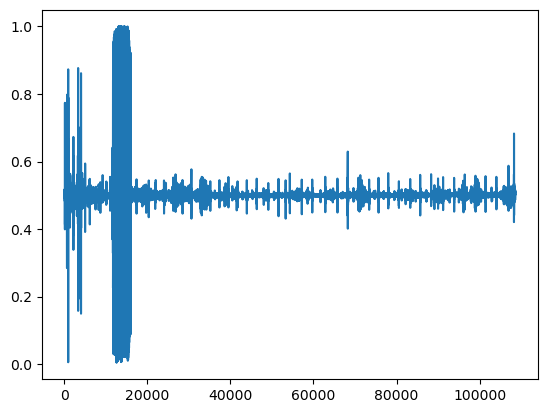

In [46]:
plt.plot(final[54])
plt.show()

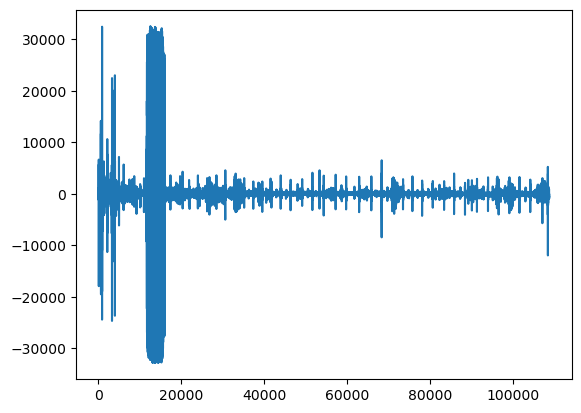

In [47]:
plt.plot(X_train[54])
plt.show()

In [48]:
X_train = final

In [49]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post",value=-1,dtype=np.float32
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1764,random_state=42)


In [50]:
X_train = np.vstack(X_train)
X_valid = np.vstack(X_valid)
#y_train = np.vstack(y_train)
#y_valid = np.vstack(y_valid)

In [51]:
print(len(X_train[0]))

235008


In [52]:
print(len(X_train[0]))
print(len(X_train[1]))
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_valid = X_valid.reshape(len(X_valid),len(X_valid[1]),1)
#y_train = y_train.reshape(len(y_train),1)
#y_valid = y_valid.reshape(len(y_valid),1)

235008
235008


In [53]:
#print(X_train.shape)
#print(y_train.shape)


In [54]:
def one_recording_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=((152384,1))),
        tf.keras.layers.Masking(mask_value=-1),
        
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same"),
        tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),
        
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same"),
        tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),
        
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same"),
        tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),

        #tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),
    
        #tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),

        #tf.keras.layers.GlobalAveragePooling1D(),

        #tf.keras.Input(shape=((152384,1))),
        #tf.keras.layers.Conv1D(6, kernel_size=(3,),activation='relu'),
        #tf.keras.layers.Conv1D(64, kernel_size=(3,), activation='relu'),
        #tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),
        #tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Flatten(),
        #tf.keras.layers.LSTM(10),

        tf.keras.layers.Dense(2, activation='softmax') 
    ])
    return model

In [55]:
def make_model(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    gap = tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same')(conv1)
    
    """
    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    """
    gap = tf.keras.layers.GlobalAveragePooling1D()(gap)
    

    output_layer = tf.keras.layers.Dense(2, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

In [56]:
#model = one_recording_model()


In [57]:
epochs = 2
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    #metrics=["sparse_categorical_accuracy",tf.keras.metrics.CategoricalAccuracy(name='acc'),tf.keras.metrics.AUC(name='auc')],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid,y_valid),
    verbose=1,
)

Epoch 1/2
7/7 [==============================] - 126s 16s/step - loss: 1.4675 - acc: 0.0000e+00 - val_loss: 0.7106 - val_acc: 0.1111 - lr: 0.0010
Epoch 2/2
1/7 [===>..........................] - ETA: 1:55 - loss: 1.3867 - acc: 0.0000e+00

KeyboardInterrupt: 

In [31]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, padding="post",value=-1,dtype=np.float32
)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [32]:
model.evaluate(X_test)
pred = model.predict(X_test)

ValueError: in user code:

    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alibelyazid/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 235008, 1), found shape=(None, 258048, 1)
